In [1]:
%cd /content
!git clone https://github.com/syunar/controlnet_poc.git
!pip install -q gradio einops transformers open_clip_torch pytorch_lightning==1.7.7 omegaconf xformers==0.0.18 triton==2.0.0 basicsr safetensors fvcore
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Linaqruf/anything-v3.0/resolve/main/anything-v3-full.safetensors -d /content/controlnet_poc/models -o anything-v3-full.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lllyasviel/ControlNet-v1-1/resolve/main/control_v11p_sd15s2_lineart_anime.pth -d /content/controlnet_poc/models -o control_v11p_sd15s2_lineart_anime.pth 

%cd /content/controlnet_poc

/content
Cloning into 'controlnet_poc'...
remote: Enumerating objects: 2416, done.
remote: Total 2416 (delta 0), reused 0 (delta 0), pack-reused 2416
Receiving objects: 100% (2416/2416), 65.19 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (997/997), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.1/708.1 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84

In [33]:
from share import *
import config
from cldm.hack import hack_everything


hack_everything(clip_skip=2)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.lineart_anime import LineartAnimeDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

preprocessor = None


model_name = 'control_v11p_sd15s2_lineart_anime'
model = create_model(f'./models/{model_name}.yaml').cpu()
model.load_state_dict(load_state_dict('./models/anything-v3-full.safetensors', location='cuda'), strict=False)
model.load_state_dict(load_state_dict(f'./models/{model_name}.pth', location='cuda'), strict=False)
model = model.cuda()
ddim_sampler = DDIMSampler(model)

logging improved.
Enabled clip hacks.
ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCross

In [34]:
def process(det, image_path, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, strength, scale, seed, eta):
    global preprocessor
    
    input_image = cv2.imread(image_path)   # reads an image in the BGR format
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)   # BGR -> RGB

    if det == 'Lineart_Anime':
        if not isinstance(preprocessor, LineartAnimeDetector):
            preprocessor = LineartAnimeDetector()

    with torch.no_grad():
        input_image = HWC3(input_image)

        if det == 'None':
            detected_map = input_image.copy()
        else:
            detected_map = preprocessor(resize_image(input_image, detect_resolution))
            detected_map = HWC3(detected_map)

        img = resize_image(input_image, image_resolution)
        H, W, C = img.shape

        detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR)

        control = 1.0 - torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [detected_map] + results

In [35]:
res = process(det='None', 
        image_path='/content/01.png', 
        prompt='', 
        a_prompt='masterpiece, best quality, ultra-detailed, illustration, disheveled hair', 
        n_prompt='longbody, lowres, bad anatomy, bad hands, missing fingers, pubic hair,extra digit, fewer digits, cropped, worst quality, low quality', 
        num_samples=1, 
        image_resolution=512, 
        detect_resolution=512, 
        ddim_steps=20, 
        strength=1.0, 
        scale=9.0, 
        seed=1234, 
        eta=1.0)

import torch
import gc
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 88, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


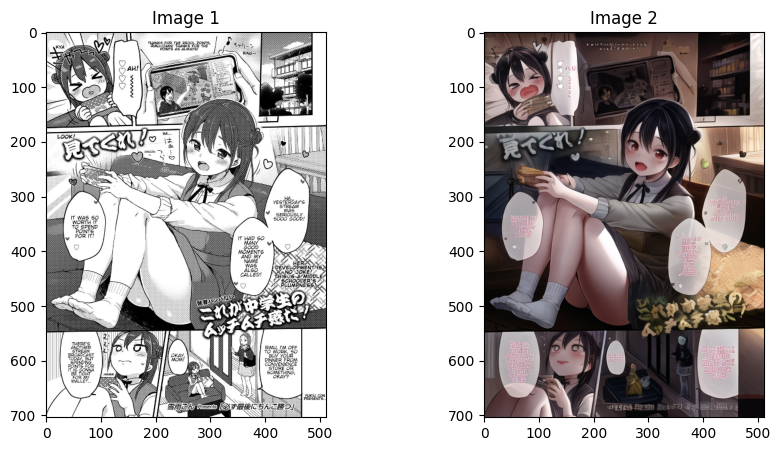

In [36]:
from matplotlib import pyplot as plt
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display image 1 on the left subplot
ax1.imshow(res[0])
ax1.set_title('Image 1')

# Display image 2 on the right subplot
ax2.imshow(res[1])
ax2.set_title('Image 2')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the figure
plt.show()